In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

/tmp/ipykernel_6558/75241850.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()], fontsize=font_size)


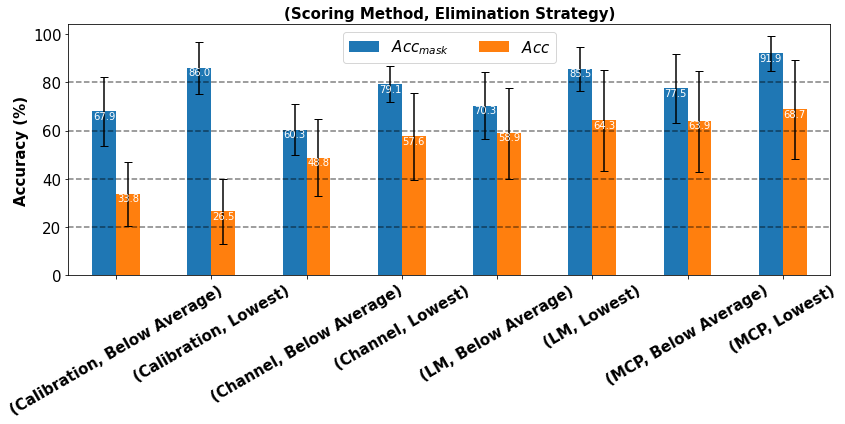

In [3]:
# measure mask accuracy and gap between mask accuracy and accuracy
poe_path = f"../old_results/process_of_elimination.csv"
poe_df = pd.read_csv(poe_path)
poe_df = poe_df.drop_duplicates()

n_shot = 0 # 3
datasets="anli cqa siqa logical_deduction_five_objects disambiguation_qa conceptual_combinations strange_stories symbol_interpretation".split()
# datasets=["cqa"]
poe_df = poe_df[(poe_df["n_shot"] == n_shot) & (poe_df["dataset"].isin(datasets))]
poe_df = poe_df.drop(columns=["seed", "model_family", "checkpoint", "method", "batch_size", "loading_precision", "sample", "prompting_method", "n_shot"])

# create a new colum that compute the difference between mask_accuracy and accuracy
# poe_df["acc_diff"] = poe_df["mask_accuracy"] - poe_df["accuracy"]
# poe_df.to_csv("mask.csv")

# sort poe_df by mask_strategy adn diff
# poe_df = poe_df.sort_values(by=['mask_accuracy', "acc_diff"], ascending=True)
# average accuracy over seed
# print(poe_df.head())
poe_df = poe_df.groupby(['scoring_method', 'mask_strategy'])
poe_mean = poe_df.mean()#.unstack()
poe_std = poe_df.std()#.unstack()


for df in [poe_mean, poe_std]:
    # convert to percentage
    df["mask_accuracy"] = df["mask_accuracy"] * 100
    df["accuracy"] = df["accuracy"] * 100    
    # rename index and columns
    df.index = df.index.set_names(["Scoring", "Mask"])
    df.index = df.index.set_levels(df.index.levels[0].str.replace('language_modeling', 'LM'), level=0)
    df.index = df.index.set_levels(df.index.levels[0].str.replace('multiple_choice_prompt', 'MCP'), level=0)
    df.index = df.index.set_levels(df.index.levels[0].str.replace('calibration', 'Calibration'), level=0)
    df.index = df.index.set_levels(df.index.levels[0].str.replace('channel', 'Channel'), level=0)
    df.index = df.index.set_levels(df.index.levels[1].str.replace('below_average', 'Below Average'), level=1)
    df.index = df.index.set_levels(df.index.levels[1].str.replace('lowest', 'Lowest'), level=1)
    df.index = df.index.map(lambda x: (x[0].replace('_', ' '), x[1].replace('_', ' ')))

# plot bar
fig, ax = plt.subplots(figsize=(12, 6))
font_size = 15
h_lines = [20, 40, 60, 80] 
poe_mean.plot.bar(
                  ax=ax, 
                  yerr=poe_std, 
                  capsize=4, 
                  rot=30,
                  )
# set legend in two columns
ax.legend(["$Acc_{mask}$", "$Acc$"], fontsize=font_size, ncol=2)
ax.set_ylabel("Accuracy (%)", fontsize=font_size, weight="bold")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size, weight="bold")
# convert yticks to int
ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()], fontsize=font_size)
# ax.set_ylim(0, 100)
ax.set_title(f"(Scoring Method, Elimination Strategy)", fontsize=font_size, weight="bold")
# plot numbers on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height() - 6),
                color='white',
                fontsize=10,
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("mask.png", dpi=300, bbox_inches='tight')

In [37]:
poe_mean

mask_accuracy   accuracy
Scoring     Mask                                   
Calibration Below Average      67.884615  33.807692
            Lowest             85.954545  26.545455
Channel     Below Average      60.307692  48.769231
            Lowest             79.076923  57.576923
LM          Below Average      70.315789  58.894737
            Lowest             85.526316  64.263158
MCP         Below Average      77.487805  63.902439
            Lowest             91.894737  68.736842

In [26]:
# find the optimal masking strategy
poe_path = f"../old_results/process_of_elimination.csv"
poe_df = pd.read_csv(poe_path)
poe_df = poe_df.drop_duplicates()

n_shot = 0 
# for dataset in "anli cqa siqa logical_deduction_five_objects disambiguation_qa conceptual_combinations strange_stories symbol_interpretation".split():
for dataset in ['cqa']:
    datasets=[dataset]
    data_df = poe_df[(poe_df["n_shot"] == n_shot) & (poe_df["dataset"].isin(datasets))]
    data_df = data_df.drop(columns=["seed", "model_family", "checkpoint", "method", "batch_size", "loading_precision", "sample", "prompting_method", "n_shot"])
    # create a new colum that compute the difference between mask_accuracy and accuracy
    data_df["acc_diff"] = data_df["mask_accuracy"] - data_df["accuracy"]
    data_df = data_df.groupby(['scoring_method', 'mask_strategy'])
    data_mean = data_df.mean()#.unstack()
    print(f"dataset: {dataset}")
    print(data_mean.sort_values(by=['accuracy'], ascending=False).iloc[:3])

dataset: cqa
                                      mask_accuracy  accuracy  acc_diff
scoring_method         mask_strategy                                   
multiple_choice_prompt lowest                 0.998     0.892     0.106
language_modeling      lowest                 0.962     0.876     0.086
channel                lowest                 0.886     0.818     0.068


In [87]:
data_mean.index.levels[1]

Index(['below_average', 'lowest'], dtype='object', name='mask_strategy')

In [88]:
cqa_mean = data_mean.applymap(lambda x: f"{x*100:.1f}")
# rename columns and rows by replacing "_" with " "
cqa_mean.index = cqa_mean.index.set_names(["Scoring", "Mask"])
cqa_mean.index = cqa_mean.index.set_levels(cqa_mean.index.levels[0].str.replace('language_modeling', 'LM'), level=0)
cqa_mean.index = cqa_mean.index.set_levels(cqa_mean.index.levels[0].str.replace('multiple_choice_prompt', 'MCP'), level=0)
cqa_mean.index = cqa_mean.index.set_levels(cqa_mean.index.levels[0].str.replace('calibration', 'CAL'), level=0)
cqa_mean.index = cqa_mean.index.set_levels(cqa_mean.index.levels[0].str.replace('channel', 'CHA'), level=0)
cqa_mean.index = cqa_mean.index.set_levels(cqa_mean.index.levels[1].str.replace('below_average', '<avg'), level=1)

cqa_mean.index = cqa_mean.index.map(lambda x: (x[0].replace('_', ' '), x[1].replace('_', ' ')))

cqa_mean = cqa_mean.rename(columns={"accuracy": "Acc",
                                     "mask_accuracy": f"Acc\\textsubscript{{mask}}", 
                                     "acc_diff": f"Acc\\textsubscript{{diff}}",  
                                     },)

cqa_mean.style.to_latex(
    buf="mask.tex",
    column_format="l|c|c|c|c",
    position="h",
    position_float="centering",
    label="tab:mask",
    caption="Masking strategy comparison",
    multicol_align="c",
    multirow_align="c",
)